# Musical Pattern Recognition

**Goal:** Identify repeating patterns (bars/phrases/sections)

In [1]:
# Loads the autoreload extension
%load_ext autoreload
# Automatically reloads all modules before executing any code
%autoreload 2

In [4]:
# External Imports
import matplotlib.pyplot as plt
import torch as torch
import numpy as np
import pypianoroll as pr

# Internal Imports
import sys, os
sys.path.append(os.path.abspath('src'))

from src.util.types import Song, PianoState, NoteSample, PianoStateSamples
from src.util.globals import resolution, beats_per_bar, num_pitches
from src.util.process_audio import quantize_pianoroll
import src.util.plot as plot


from src.dataset.load import (
    load_multi_track,
    get_track_by_instrument,
)

unique values = [0 1]


/Users/romanhudaj/Desktop/projects/ML/MusicGen/src/util/plot.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  return ax


<Axes: xlabel='Time (tick-resolution = 0.125 beats)', ylabel='Pitch'>

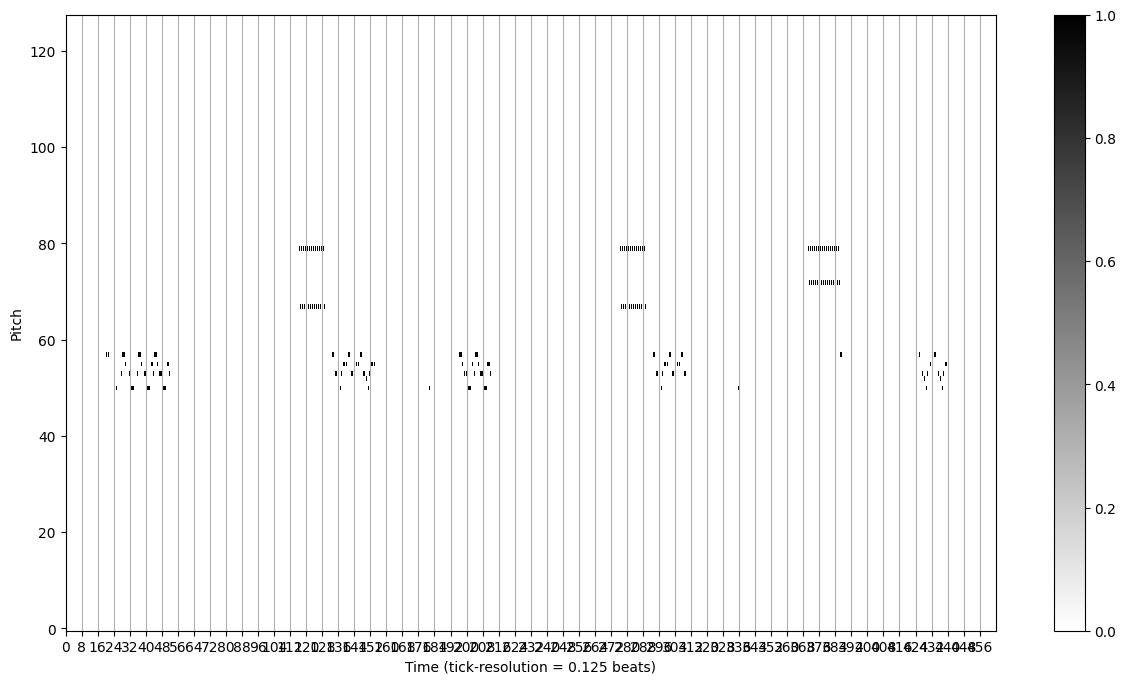

In [14]:
# Testing Sample
dir_id = 'TRAAAGR128F425B14B'
song_id = 'b97c529ab9ef783a849b896816001748'

desired_instrument = 'Guitar'

# EXAMPLE: Load a NPZ file into a Multitrack object.
multi_track = load_multi_track(f'A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.npz')
bass_track = get_track_by_instrument(multi_track, desired_instrument)

# Binarize Note Velocity!
binary_track = bass_track.binarize()

track_pr = binary_track.pianoroll.astype(int)

print('unique values =', np.unique(track_pr))

# Quantize!
track_pr = quantize_pianoroll(track_pr, resolution//4)


plot.plot_pianoroll(track_pr, tick_resolution=resolution*8)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarities_sklearn(windows):
    """
    Using scikit-learn's optimized implementation
    """
    # Reshape windows to 2D (num_windows, num_features)
    if windows.ndim == 3:  # (num_windows, time, pitch)
        windows_flat = windows.reshape(windows.shape[0], -1)
    else:
        windows_flat = windows

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(windows_flat)

    return similarity_matrix

def find_repeating_sections(piano_roll: np.ndarray, X_bars=4):
    """
    Find repeating sections in piano roll

    Args:
        piano_roll: 2D array (time, pitch)
        X_bars: number of bars per window
        beats_per_bar: typically 4
        resolution: time steps per beat (4 = 16th notes)
    """

    # Calculate window size
    window_size = X_bars * beats_per_bar
    step_size = beats_per_bar  # Step by 1 bar

    # Sliding window view
    windows: np.ndarray = np.lib.stride_tricks.sliding_window_view(
        piano_roll,
        window_shape=(window_size, piano_roll.shape[1]),
        axis=(0, 1)
    )[::step_size, 0]  # Take every step_size-th window

    # Flatten windows for similarity computation
    windows_flat = windows.reshape(windows.shape[0], -1)

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(windows_flat)

    return len(windows), similarity_matrix

def plot_sim_matrix(SM):
	plt.figure(figsize=(10, 8))
	plt.imshow(SM, cmap='hot', interpolation='nearest')
	plt.colorbar(label='Cosine Similarity')
	plt.title('Self-Similarity Matrix')
	plt.xlabel('Window Index')
	plt.ylabel('Window Index')
	plt.show()

def find_similair_pairs(sm: np.ndarray, threshold=0.99) -> list[tuple[int,int,float]]:
    ''' Find similar pairs (excluding diagonal) '''
    similar_pairs = []
    for i in range(len(sm)):
        for j in range(i+1, len(sm)):
            if sm[i,j] > threshold:
                similar_pairs.append((i, j, sm[i,j]))
    return similar_pairs

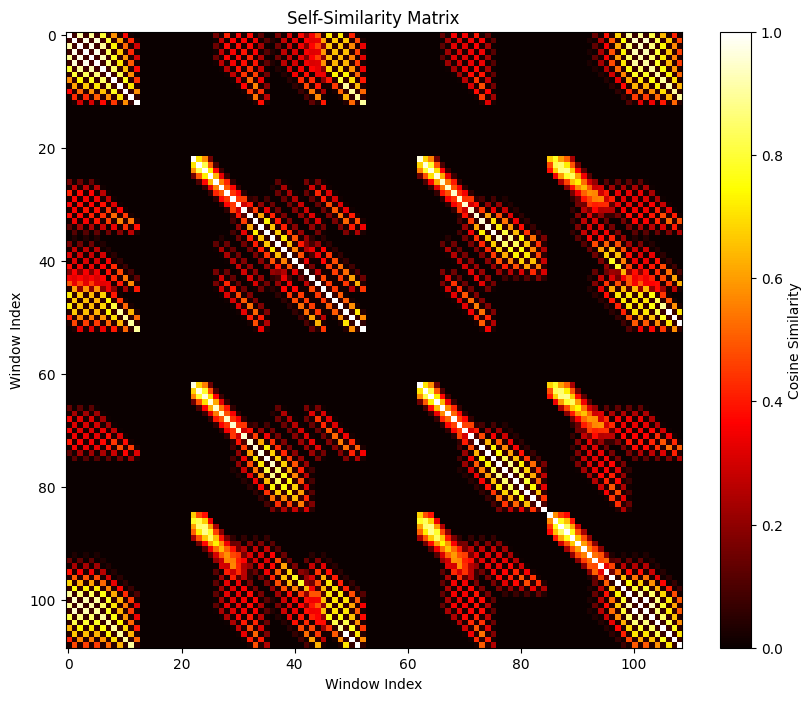

[1,3] -- 0.9746794344808972
[1,5] -- 0.9537161360096119
[2,4] -- 0.9753048303966929
[3,5] -- 0.9784921095801643
[22,62] -- 0.9666389043738994
[23,63] -- 0.9666389043738997
[24,64] -- 0.9666389043738965
[25,65] -- 0.9674162518961555
[26,66] -- 0.9568961842055105
[29,69] -- 0.9503305333614088
[30,70] -- 0.9521149819310432
[31,71] -- 0.9542913007102258
[32,72] -- 0.9570044959027072
[33,73] -- 0.9608917126479826
[34,74] -- 0.9744366648890708
[35,75] -- 0.9885710532241642
[49,106] -- 1.0
[50,107] -- 1.0
[51,108] -- 0.9999999999999999
[100,102] -- 0.9999999999999991


In [16]:
repeat_resolution_bars = 8

n_windows, sim_matrix = find_repeating_sections(
	track_pr,
	repeat_resolution_bars
)

plot_sim_matrix(sim_matrix)

sim_pairs = find_similair_pairs(sim_matrix, threshold=0.95)
print(
    *list(map(
		lambda pair: f'[{pair[0]},{pair[1]}] -- {pair[2]}',
      	sim_pairs
	)),
    sep='\n'
)

In [17]:
# Create groups:
def create_groups(sim_pairs, n_windows):
    groups = []
    bar_groups = [-1] * n_windows  # assign each bar to a group

    for a, b, similarity in sim_pairs:
        if bar_groups[a] == -1 and bar_groups[b] == -1:
            # Both items are unassigned - create new group
            group_id = len(groups)
            bar_groups[a] = group_id
            bar_groups[b] = group_id
            groups.append([a, b])

        elif bar_groups[a] == -1 and bar_groups[b] != -1:
            # Add a to b's group
            groups[bar_groups[b]].append(a)
            bar_groups[a] = bar_groups[b]

        elif bar_groups[a] != -1 and bar_groups[b] == -1:
            # Add b to a's group
            groups[bar_groups[a]].append(b)
            bar_groups[b] = bar_groups[a]

        elif bar_groups[a] != bar_groups[b]:
            # Both belong to different groups - merge them
            print('Merging!!')
            group_a = bar_groups[a]
            group_b = bar_groups[b]

            # Move all items from group_b to group_a
            groups[group_a].extend(groups[group_b])

            # Update group assignments for all items that were in group_b
            for item in groups[group_b]:
                bar_groups[item] = group_a

            # Clear group_b
            groups[group_b] = []

        # If bar_groups[a] == bar_groups[b] and both != -1,
        # they're already in the same group - do nothing

    # Filter out empty groups
    final_groups = [group for group in groups if group]

    return final_groups

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_track(data: pr.Track, desired_instrument: str, with_bars=True, line_spacing_bars=1, groups=None):

    num_bars = int(data.pianoroll.shape[0] / beats_per_bar)

    # plot the track (with bars)
    fig, ax = plt.subplots(figsize=(12, 6))
    pr.plot_track(data, ax=ax)

    # Define more distinct colors for different groups
    colors = ['#FF0000', '#0000FF', '#00FF00', '#FF8000', '#8000FF',
              '#FF0080', '#00FFFF', '#FFFF00', '#FF8080', '#8080FF',
              '#80FF80', '#FF80FF', '#80FFFF', '#FFB366', '#B366FF',
              '#66FFB3', '#FFD700', '#DC143C', '#32CD32', '#FF1493']

    # Add vertical lines for bar boundaries with group coloring
    if with_bars:
        if groups is not None:
            # Create a mapping from bar index to group color
            bar_to_color = {}
            for group_idx, group in enumerate(groups):
                color = colors[group_idx % len(colors)]  # Cycle through colors if more groups than colors
                for bar_idx in group:
                    bar_to_color[bar_idx] = color

            # Color background regions for each bar based on groups
            for bar_idx in range(num_bars):
                bar_start = bar_idx * beats_per_bar
                bar_end = (bar_idx + 1) * beats_per_bar
                color = bar_to_color.get(bar_idx, None)  # Get group color or None
                if color is not None:  # Only color if bar is in a group
                    ax.axvspan(xmin=bar_start, xmax=bar_end, color=color, alpha=0.9, zorder=0)

        else:
            # Default behavior - all bars in red
            for bar in range(1, num_bars+1, line_spacing_bars):
                bar_position = bar * beats_per_bar
                ax.axvline(x=bar_position, color='red', linestyle='--', alpha=0.7, linewidth=1)

    # Add labels
    title = f'{desired_instrument} Track - {num_bars} bars'
    if groups is not None:
        title += f' ({len(groups)} groups)'
    ax.set_title(title)
    ax.set_xlabel('Time (beats)')

    # Add legend if groups are provided
    if groups is not None:
        legend_elements = []
        for group_idx, group in enumerate(groups):
            color = colors[group_idx % len(colors)]
            legend_elements.append(plt.Line2D([0], [0], color=color, linestyle='--',
                                            label=f'Group {group_idx+1} ({len(group)} bars)'))
        ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

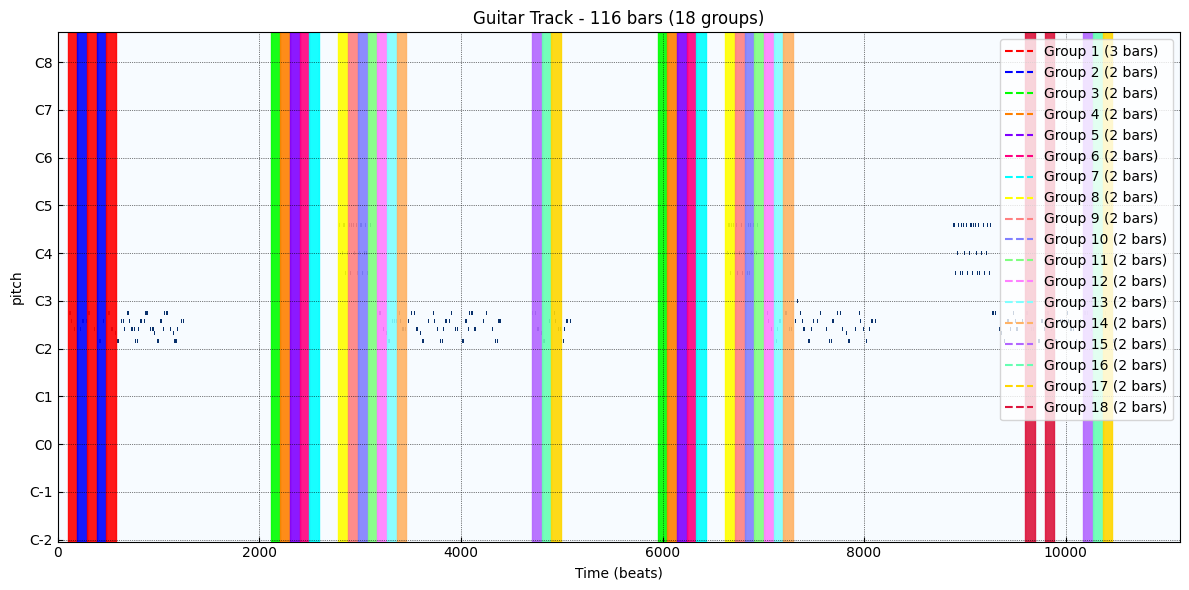

In [20]:
groups = create_groups(sim_pairs, n_windows)
plot_track(binary_track, desired_instrument, True, 8, groups)